# 1.4f: Nearest Neighbor Analysis

This notebook examines each token's distance to its nearest neighbor to reveal clustering structure.

## The Question

The pairwise distance distribution (1.4c) shows complex structure:
- A singularity at distance = 0 (duplicates)
- Broad distribution extending to ~2.0
- Unclear boundary between "clustered" and "normal" tokens

But from each token's perspective: **How far is its closest neighbor?**

If there's a dense core separated by a void from ambient tokens, we should see:
- **Bimodal distribution**: One peak at small distances (core), one at larger distances (ambient)
- **A gap**: Few tokens with intermediate nearest-neighbor distances
- **Clear threshold**: Distance cutoff that separates the two populations

If it's a continuum ("accreting"), the gap will be filled in.

## Method

We'll:
1. Load the distance matrix from 1.4b
2. For each token, find its minimum distance (nearest neighbor)
3. Plot histogram of nearest-neighbor distances
4. Look for gaps and natural thresholds

## Parameters

In [9]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Visualization
HIST_BINS = 100
FIGSIZE = (12, 6)
DPI = 200

# Zoomed histogram (set None to skip)
ZOOM_XMIN = 0.0
ZOOM_XMAX = 0.05
ZOOM_BINS = 100

## Imports

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Load Distance Matrix

In [11]:
# Load distances and token IDs from 1.4b
tensor_path = Path(f"../tensors/{MODEL_NAME}/1.4b_overdensity_distances.safetensors")
data = load_file(tensor_path)
dists = data['distances']
spike_token_ids = data['spike_token_ids']

print(f"Loaded distance matrix from {tensor_path}")
print(f"  Shape: {dists.shape}")
print(f"  Tokens: {len(spike_token_ids):,}")

Loaded distance matrix from ../tensors/Qwen3-4B-Instruct-2507/1.4b_overdensity_distances.safetensors
  Shape: torch.Size([20373, 20373])
  Tokens: 20,373


## Compute Nearest Neighbor Distances

In [12]:
print("\nComputing nearest neighbor distances...\n")

# For each token, find minimum distance (excluding self on diagonal)
# Set diagonal to infinity so it's not selected as minimum
dists_no_diag = dists.clone()
dists_no_diag.fill_diagonal_(float('inf'))

# Find minimum distance for each token
nearest_neighbor_dists, nearest_neighbor_ids = dists_no_diag.min(dim=1)

print(f"✓ Nearest neighbor distances computed")
print(f"  {len(nearest_neighbor_dists):,} tokens")


Computing nearest neighbor distances...

✓ Nearest neighbor distances computed
  20,373 tokens


## Statistics

In [13]:
print(f"\nNearest neighbor distance statistics:\n")

# Convert to numpy
nn_dists_np = nearest_neighbor_dists.numpy()

# Basic stats
print(f"  Min:     {nn_dists_np.min():.10f}")
print(f"  Max:     {nn_dists_np.max():.10f}")
print(f"  Mean:    {nn_dists_np.mean():.10f}")
print(f"  Median:  {np.median(nn_dists_np):.10f}")
print(f"  Std:     {nn_dists_np.std():.10f}")
print()

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print(f"  Percentiles:")
for p in percentiles:
    val = np.percentile(nn_dists_np, p)
    print(f"    p{p:2d}: {val:.10f}")
print()

# Count exact zeros (tokens with duplicate neighbors)
n_zeros = (nearest_neighbor_dists == 0).sum().item()
print(f"Tokens with nearest neighbor at distance = 0: {n_zeros:,}")
print(f"  ({n_zeros / len(nearest_neighbor_dists) * 100:.2f}% of tokens)")


Nearest neighbor distance statistics:

  Min:     0.0000000000
  Max:     1.4865580797
  Mean:    0.7729594111
  Median:  0.9180006981
  Std:     0.4007497728

  Percentiles:
    p 1: 0.0000000000
    p 5: 0.0000000000
    p10: 0.0000000000
    p25: 0.5052329302
    p50: 0.9180006981
    p75: 1.0821263790
    p90: 1.1799398661
    p95: 1.2292169333
    p99: 1.2987020016

Tokens with nearest neighbor at distance = 0: 2,100
  (10.31% of tokens)


## Full Distribution Histogram


Creating full distribution histogram...



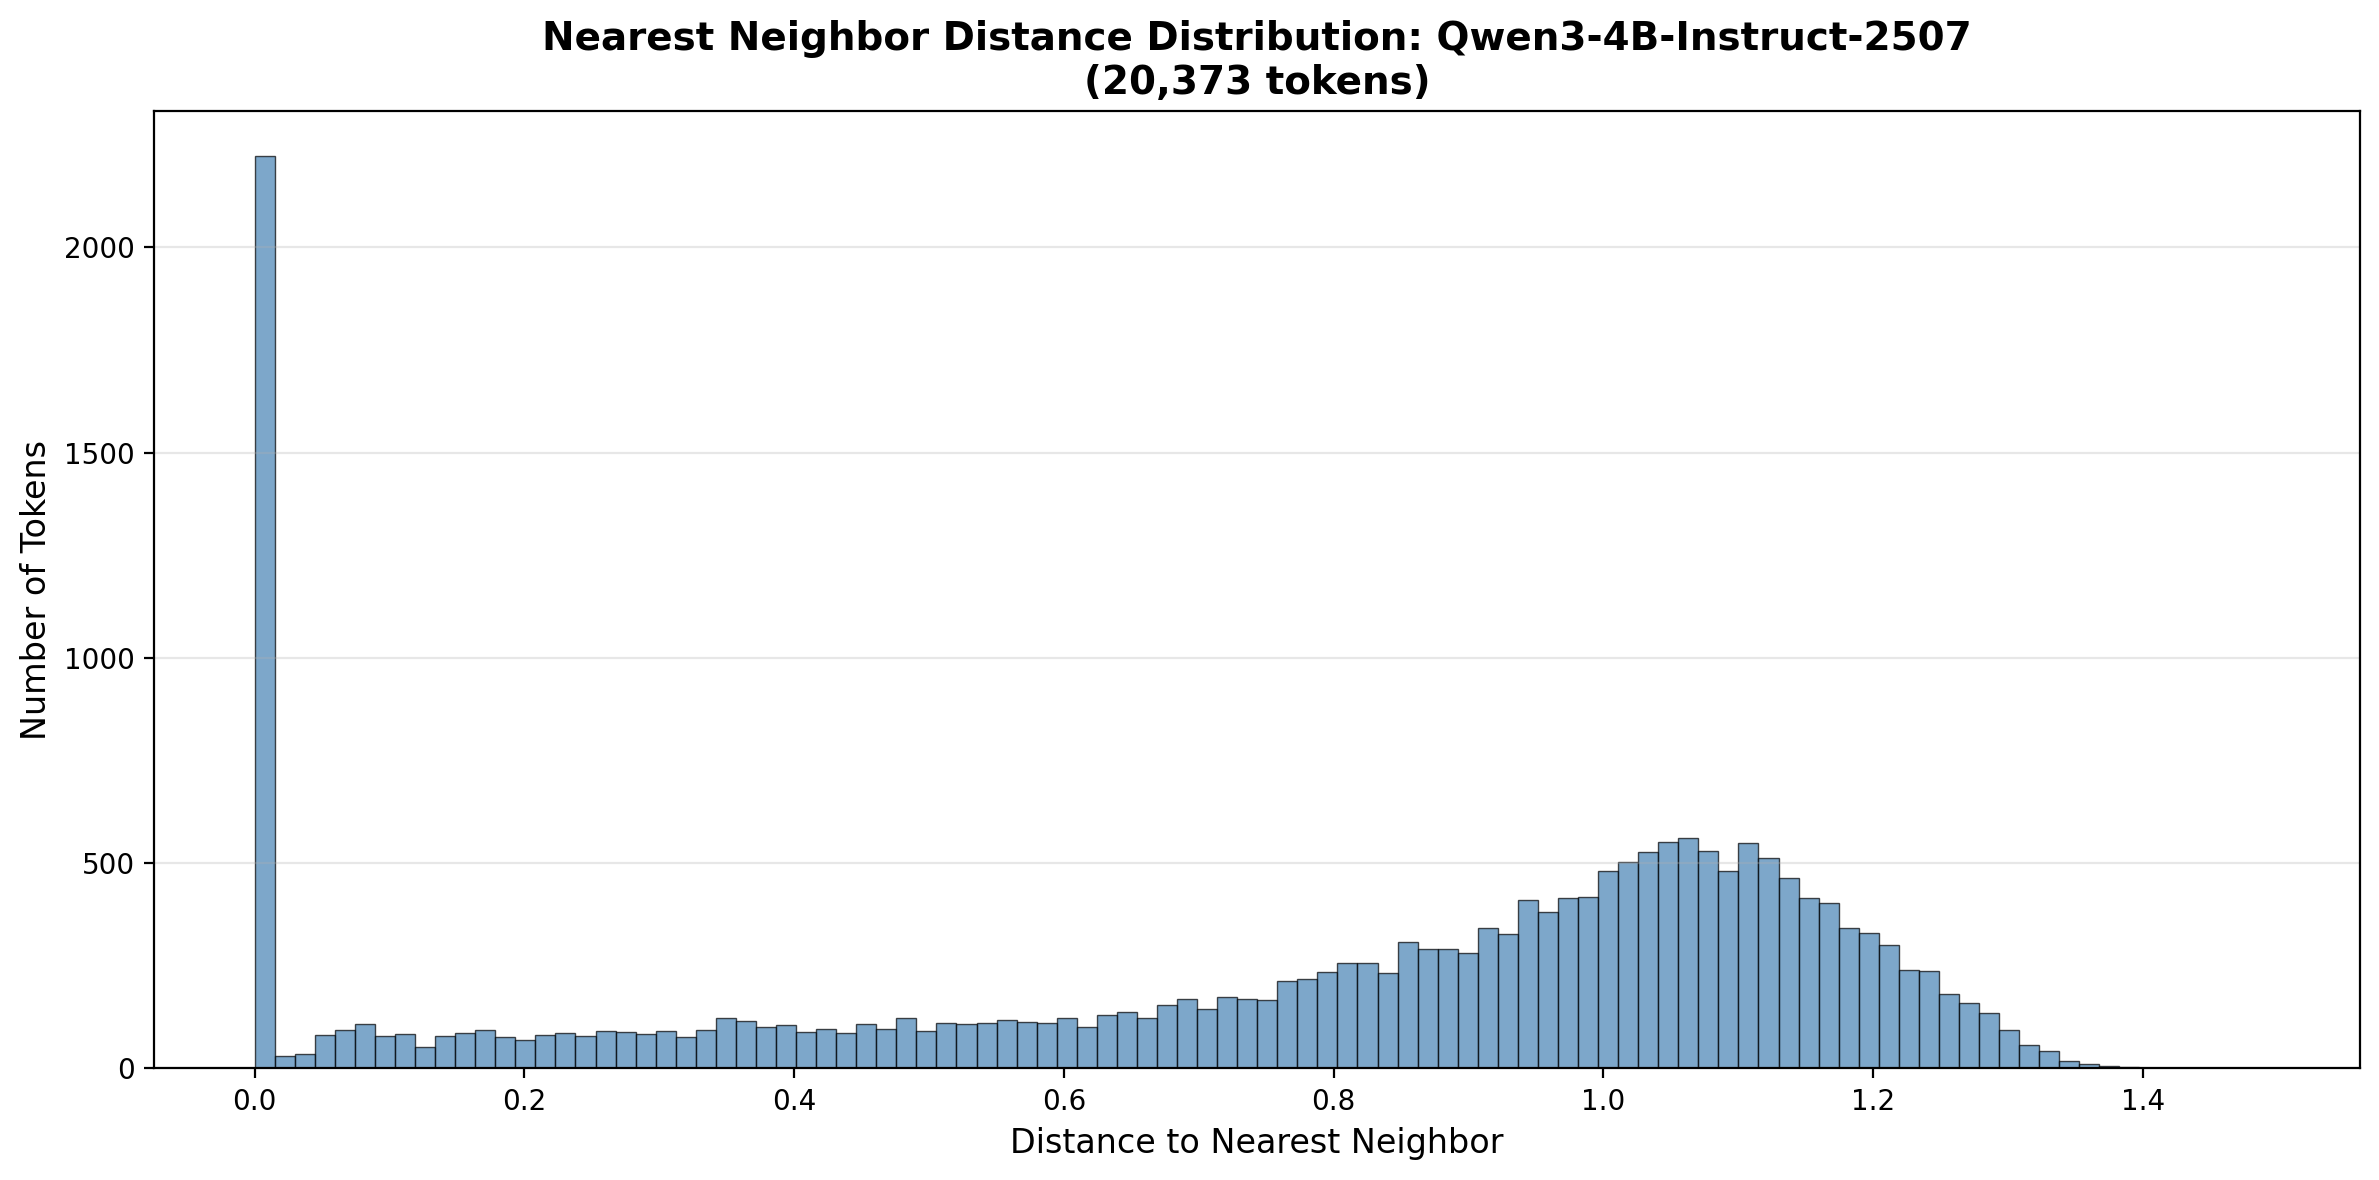

✓ Full histogram complete


In [14]:
print(f"\nCreating full distribution histogram...\n")

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Histogram
ax.hist(nn_dists_np, bins=HIST_BINS, color='steelblue', alpha=0.7, 
        edgecolor='black', linewidth=0.5)

# Formatting
ax.set_xlabel('Distance to Nearest Neighbor', fontsize=12)
ax.set_ylabel('Number of Tokens', fontsize=12)
ax.set_title(f'Nearest Neighbor Distance Distribution: {MODEL_NAME}\n({len(spike_token_ids):,} tokens)',
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Full histogram complete")

## Zoomed Histogram

Examine small distances to look for gaps and clustering structure.


Creating zoomed histogram: [0.0, 0.05]

Tokens in range: 2,313 (11.35% of total)



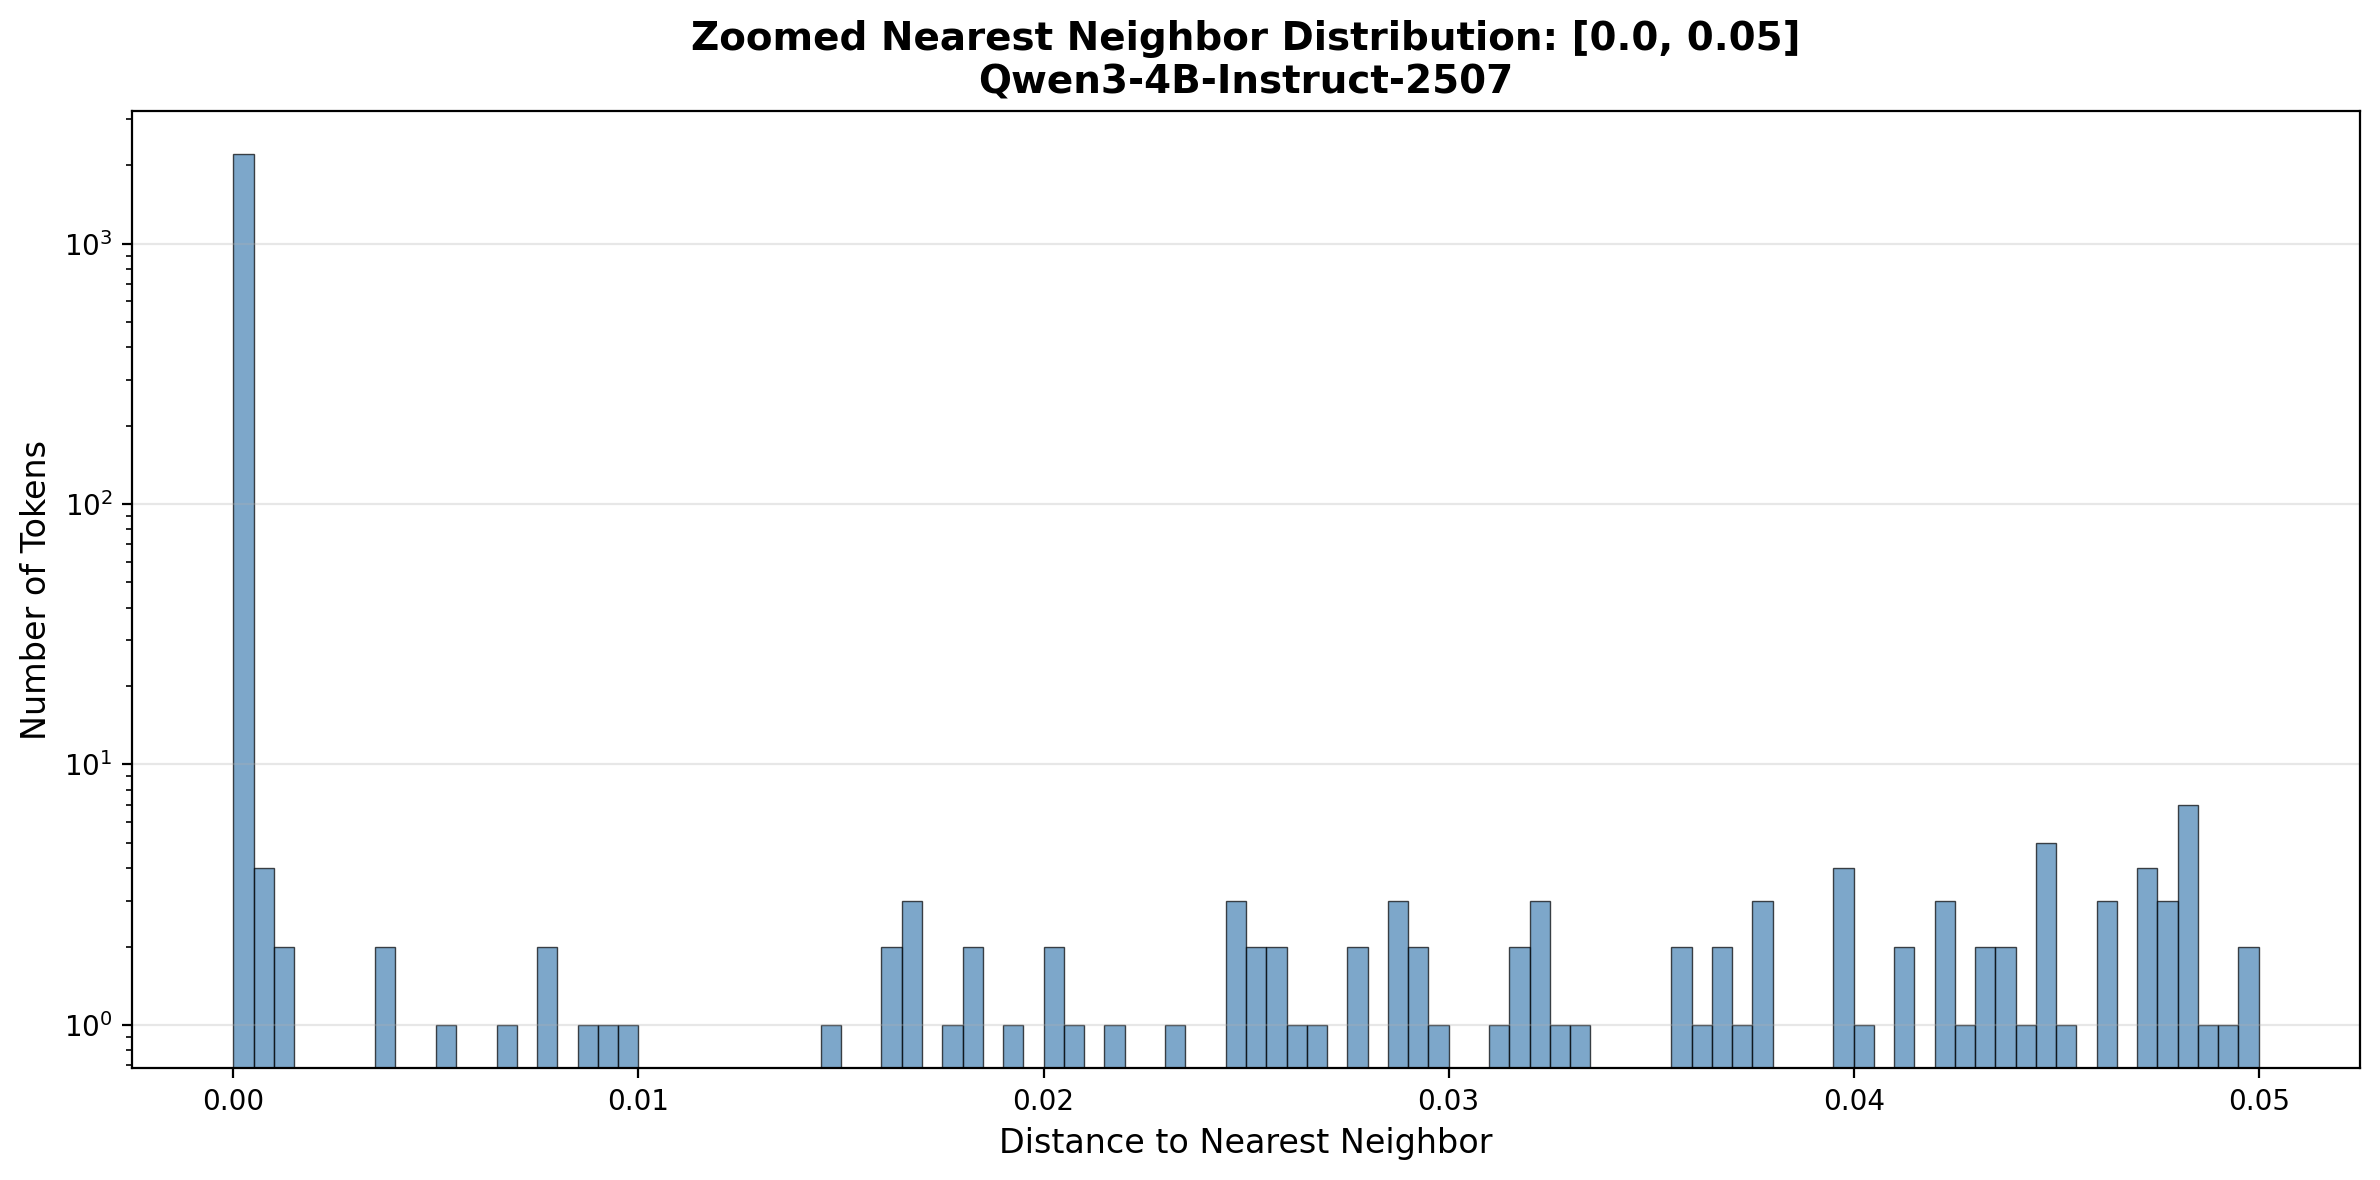

✓ Zoomed histogram complete


In [15]:
if ZOOM_XMIN is not None and ZOOM_XMAX is not None:
    print(f"\nCreating zoomed histogram: [{ZOOM_XMIN}, {ZOOM_XMAX}]\n")
    
    # Filter to zoom range
    zoom_mask = (nn_dists_np >= ZOOM_XMIN) & (nn_dists_np <= ZOOM_XMAX)
    nn_dists_zoom = nn_dists_np[zoom_mask]
    
    print(f"Tokens in range: {len(nn_dists_zoom):,} ({len(nn_dists_zoom)/len(nn_dists_np)*100:.2f}% of total)\n")
    
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    
    # Histogram with explicit range
    ax.hist(nn_dists_zoom, bins=ZOOM_BINS, range=(ZOOM_XMIN, ZOOM_XMAX),
            color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Formatting
    ax.set_xlabel('Distance to Nearest Neighbor', fontsize=12)
    ax.set_ylabel('Number of Tokens', fontsize=12)
    ax.set_title(f'Zoomed Nearest Neighbor Distribution: [{ZOOM_XMIN}, {ZOOM_XMAX}]\n{MODEL_NAME}',
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xscale('linear')
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Zoomed histogram complete")
else:
    print("\nZoomed histogram skipped (set ZOOM_XMIN and ZOOM_XMAX to enable)")

## Count Tokens Below Thresholds

In [16]:
print(f"\nCounting tokens below distance thresholds:\n")

# Thresholds to examine
thresholds = [0.05, 0.1, 0.15, 0.2]

print(f"{'Threshold':<15} {'Tokens Below':<15} {'Percentage'}")
print("-" * 50)

for thresh in thresholds:
    count = (nn_dists_np < thresh).sum()
    pct = count / len(nn_dists_np) * 100
    print(f"{thresh:<15.0e} {count:<15,} {pct:>6.2f}%")

print()
print(f"Total tokens: {len(nn_dists_np):,}")


Counting tokens below distance thresholds:

Threshold       Tokens Below    Percentage
--------------------------------------------------
5e-02           2,313            11.35%
1e-01           2,629            12.90%
1e-01           2,867            14.07%
2e-01           3,146            15.44%

Total tokens: 20,373


## Observations

Look for:

- **Spike at zero**: Tokens that have exact duplicates as nearest neighbors
- **Gap**: A range of distances with few tokens (indicates separation between core and ambient)
- **Bimodal structure**: Two distinct populations (clustered vs. scattered)
- **Natural threshold**: A distance that cleanly separates "core" from "ambient" tokens

If there's a clean gap, we can use it to define a threshold for identifying the dense core.

If the distribution is continuous (no gap), it suggests the structure is more like an accretion disk—density gradually decreasing rather than discrete clusters in a void.